# QG Inversion

In [1]:
import autoroot
import jax
import jax.numpy as jnp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read input SSH

In [2]:
ds = xr.open_dataset(
    "/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc"
)
ds = xr.open_dataset(
    "/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc",
    decode_times=False,
).assign_coords(time=lambda ds: pd.to_datetime(ds.time))


# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [3]:
from jaxsw._src.domain.base import Domain
import jaxsw._src.models.qg.qg_r as qg

In [26]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

dx, dy, f = qg.lat_lon_deltas(lon, lat)
nx, ny = len(lon), len(lat)
dx = dy = jnp.mean(jnp.asarray([dx, dy]))
f0 = np.asarray(np.mean(f))
dt = 600  # 10 mins / 600 s
c1 = 2.7  # 25_000 #1.5
g = 9.91
tol = 1e-15
n_iterations = 144
print(f0, c1, g)


nx = lon.size
ny = lat.size

8.96745305945707e-05 2.7 9.91


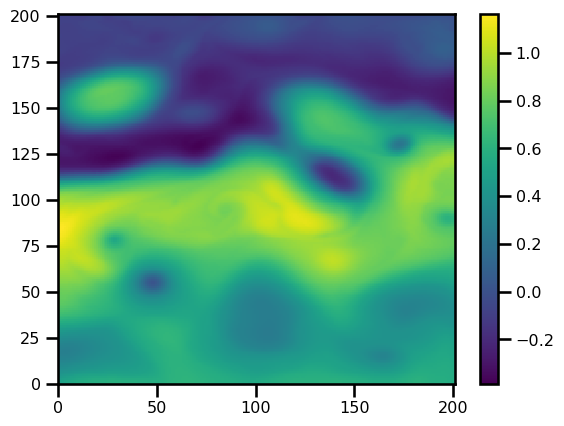

In [27]:
plt.figure()
plt.pcolormesh(ssh.T)
plt.colorbar()

In [28]:
def enforce_boundaries_helmholtz(u, u_bc, kappa):
    u = u.at[0, :].set(-kappa * u_bc[0, :])
    u = u.at[-1, :].set(-kappa * u_bc[-1, :])
    u = u.at[:, 0].set(-kappa * u_bc[:, 0])
    u = u.at[:, -1].set(-kappa * u_bc[:, -1])
    return u

In [29]:
from jaxsw._src.utils.dst_solver import inverse_elliptical_dst_solver

In [32]:
g = 9.91
c1 = 1.5
kappa = (f0 / c1) ** 2

ssh = jnp.copy(ssh)
ssh_bv = jnp.copy(ssh)

# ssh -> psi
psi = qg.ssh_to_streamfn(ssh, f0)

# psi -> pv
q_ref = qg.streamfn_to_pvort(psi, dx, dy, f0=f0, c1=c1, accuracy=1)
q_ref = enforce_boundaries_helmholtz(q_ref, psi, kappa=kappa)

# do interior case
psi_bv = psi.at[1:-1, 1:-1].set(0.0)
q_bv = qg.streamfn_to_pvort(psi_bv, dx, dy, f0=f0, c1=c1, accuracy=1)
q_bv = enforce_boundaries_helmholtz(q_bv, psi_bv, kappa=kappa)

# remove interior
q_in = q_ref[1:-1, 1:-1] - q_bv[1:-1, 1:-1]

# do the inversion
inv = inverse_elliptical_dst_solver(q_in, nx, ny, dx, dy, kappa)

psi_rec = psi.at[1:-1, 1:-1].set(inv)
ssh_rec = qg.streamfn_to_ssh(psi_rec, f0=f0)

print(np.max(np.abs(ssh_rec - ssh)))

1.4432899320127035e-15


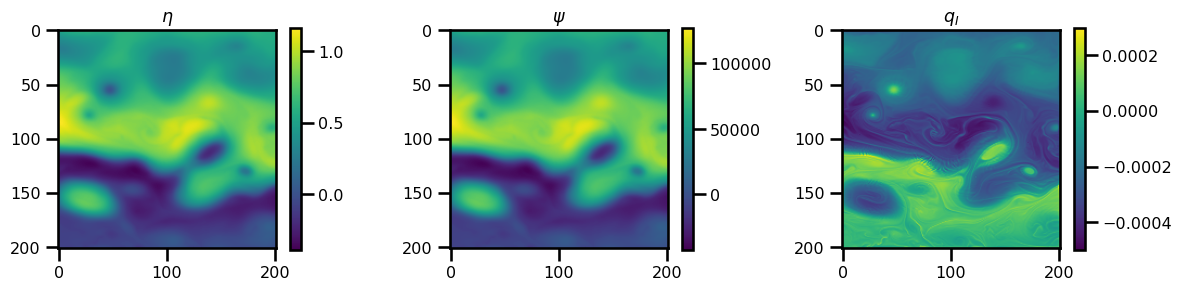

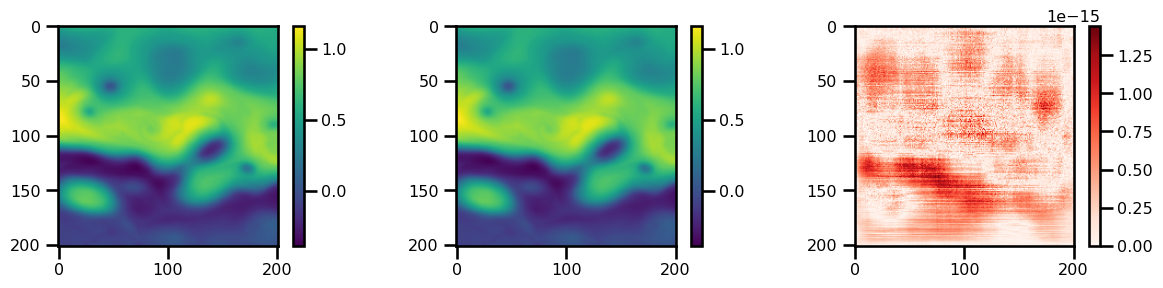

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

pts = ax[0].imshow(ssh.T, cmap="viridis")
ax[0].set(title=r"$\eta$")
plt.colorbar(pts)

pts = ax[1].imshow(psi.T, cmap="viridis")
ax[1].set(title=r"$\psi$")
plt.colorbar(pts)

pts = ax[2].imshow(q_ref.T, cmap="viridis")
ax[2].set(title=r"$q_I$")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

pts = ax[0].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[1].imshow(ssh_rec.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[2].imshow(jnp.abs(ssh_rec.T - ssh.T), cmap="Reds")
plt.colorbar(pts)


plt.tight_layout()
plt.show()

In [34]:
from typing import Optional

### Conjugate Gradient

In [205]:
lon = ds.lon.values
lat = ds.lat.values
ssh = jnp.asarray(ds.ssh[0].values.T)

dx, dy, f = qg.lat_lon_deltas(lon, lat)
nx, ny = len(lon), len(lat)
# dx = dy = jnp.mean(jnp.asarray([dx, dy]))
f0 = np.asarray(np.mean(f))
dt = 600  # 10 mins / 600 s
c1 = 2.7  # 25_000 #1.5
g = 9.91
tol = 1e-15
n_iterations = 144
print(f0, c1, g)


nx = lon.size
ny = lat.size

8.96745305945707e-05 2.7 9.91


In [206]:
g = 9.91
c1 = 1.5
kappa = (f0 / c1) ** 2

ssh = jnp.copy(ssh)

# ssh -> psi
psi = qg.ssh_to_streamfn(ssh, f0)

# psi -> pv
q = qg.streamfn_to_pvort(psi, dx, dy, f0=f0, c1=c1, accuracy=1)
q = enforce_boundaries_helmholtz(q, psi, kappa=kappa)

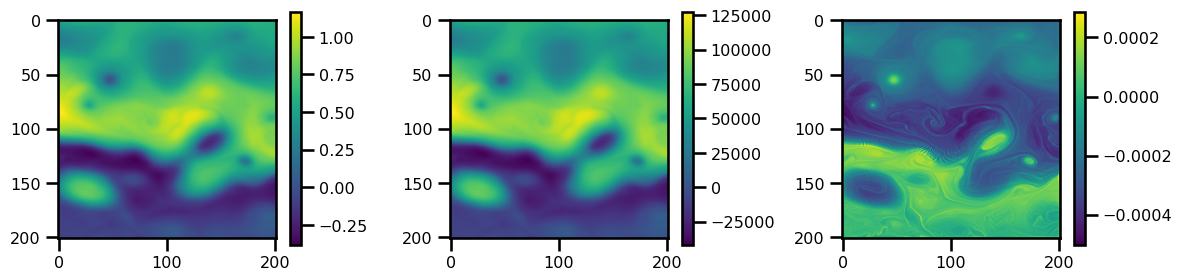

In [207]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

pts = ax[0].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[1].imshow(psi.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[2].imshow(q.T, cmap="viridis")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [208]:
from jaxopt import linear_solve
from jaxsw._src.utils.linear_solver import conjugate_gradient, steepest_descent


def pv_to_streamfn(
    q: Array,
    psi_bc,
    dx,
    dy,
    f0: float = 1e-5,
    c1: float = 2.7,
    tol: float = 1e-5,
    maxiters: int = 100,
    accuracy: int = 1,
) -> Array:
    kappa = (f0 / c1) ** 2

    # define matrix multiplcation term
    def matvec_Lp(psi):
        # psi = enforce_boundaries_psi(psi, psi_bc)
        q = qg.streamfn_to_pvort(psi, dx, dy, f0=f0, c1=c1, accuracy=accuracy)
        q = enforce_boundaries_helmholtz(q, psi_bc, kappa)
        return q

    pnew = linear_solve.solve_cg(matvec=matvec_Lp, b=q, tol=tol, maxiter=maxiters)

    return pnew


def enforce_boundaries_zero(u):
    u = u.at[0, :].set(0.0)
    u = u.at[-1, :].set(0.0)
    u = u.at[:, 0].set(0.0)
    u = u.at[:, -1].set(0.0)
    return u


def enforce_boundaries_psi(u, u_bc):
    u = u.at[0, :].set(u_bc[0, :])
    u = u.at[-1, :].set(u_bc[-1, :])
    u = u.at[:, 0].set(u_bc[:, 0])
    u = u.at[:, -1].set(u_bc[:, -1])
    return u

In [202]:
# calculate stream function
tol = 1e-15
maxiters = 10_000


psi_rec = pv_to_streamfn(
    q=q,
    psi_bc=psi,
    dx=dx,
    dy=dy,
    f0=f0,
    c1=c1,
    tol=tol,
    maxiters=maxiters,
    accuracy=1,
)
# psi_rec = pv_to_streamfn(
#     q=q_in, psi_bc=psi[1:-1,1:-1], dx=dx[1:-1,1:-1], dy=dy[1:-1,1:-1],
#     f0=f0,c1=c1,
#     tol=tol, maxiters=maxiters, accuracy=1)

In [203]:
# psi_rec = psi.at[1:-1,1:-1].set(psi_rec)
ssh_rec = qg.streamfn_to_ssh(psi_rec, f0=f0)

print(np.max(np.abs(ssh_rec - ssh)))

8095.946362564549


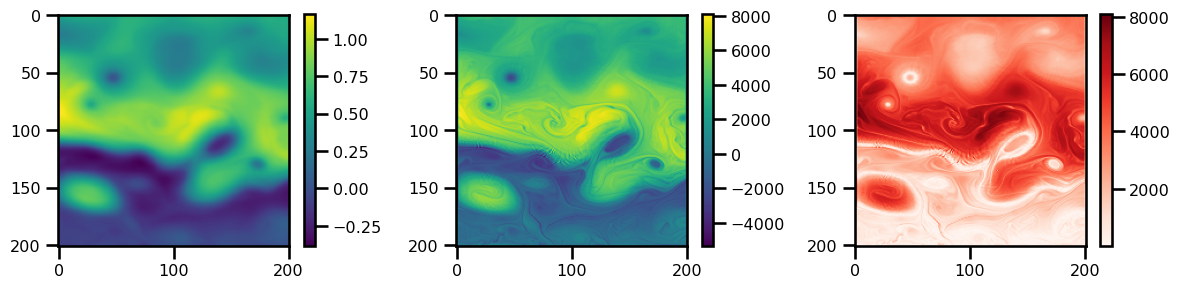

In [204]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

pts = ax[0].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[1].imshow(ssh_rec.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[2].imshow(jnp.abs(ssh_rec.T - ssh.T), cmap="Reds")
plt.colorbar(pts)


plt.tight_layout()
plt.show()